## Social Network Analysis with Python 

  ================================================================
# Ismail Ougamane

  ================================================================

***

### Objectives of this lab:
- Data wrangling with Python
- Formatting Data for SNA
- SNA with networkx (micro, macro level metrics)
- Network visualization

### 1. Preparing Data 

The first step is getting our Social Network data. For the purpose of this lab we will use the Enron Database. This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation.

As part of their inquiries, The Federal Energy Regulatory Commission used an extensive collection of emails from Enron employees. The Enron corpus is one of the only publicly available collections of emails available for research. This dataset also provides a fascinating playground for citizen data scientists.


You can download the Database from the following link: http://www.cs.cmu.edu/~enron/


The Original Enron Dataset contains a set of folders that organizes a collection of mailboxes by person and folder. Data wrangling is a routine problem, and this section should give you some perspective and some appreciation for it.



#### Getting all the emails

The main folder is maildir, which holds all the personal accounts. Our first task is to load the required libraries and create a list of available emails. 

You will need to get all files in the inboxes of users. To do that, you need to iterate on all subdirectories 'inbox' within the maildir folder. It is useful to store the path of the files in a data structure before starting to read each file. 

The choice of the inboxes garantees retrieving all possible exchanges, including multi destination emails   

In [1]:
import glob

import pickle
import re
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

users = glob.glob( '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/*')
users


['/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/489.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/706.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/451.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/351.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/297.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/296.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/466.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/556.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/516.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/362.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/312.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/394.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/453.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/allen-p/sent/cur/98.',
 '/home/ou/Documents/SNA Lab/maildi

In [2]:
# Keep only Employees who sent emails 
users = glob.glob( '/home/ou/Documents/SNA Lab/maildir/maildir/**/sent/**/*')
users

['/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/40.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/46.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/49.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/37.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/51.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/4.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/41.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/35.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/47.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/17.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/19.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/45.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/8.',
 '/home/ou/Documents/SNA Lab/maildir/maildir/derrick-j/sent/cur/6.',
 '/home/ou/Documents/SN

Make sure to clean your data from any System file etc. Then read the files within the subdirectories. Beware of encoding problems.

In [3]:
# Read all the emails into a dictionary or a data structure of your choice
# You can use the path or username as key and the content of the email as value.

##### Getting Employees username/emails

We'd also like to get a list of Employees' username (name on the folders) and their emails. Clean your data accordingly. 

Note: You will need to access the first file from each subdirectory 'sent' in order to retrieve the email of an Employee. We use the 'sent' subdirectory because an email can have only one sender but multiple recipients.

You can use Regular Expressions to retrieve the emails from the files.

In [40]:
   
data = []
C = []

users = glob.glob( '/home/ou/Documents/SNA Lab/maildir/maildir/**/inbox/cur/1.')
users1 = glob.glob( '/home/ou/Documents/SNA Lab/maildir/maildir/**/inbox/cur/2.')
users3 = users +users1
for filename in users3:

    
    in_file = open(filename,'rb') # open file lorem.txt for reading text data
    contents = in_file.read()         # read the entire file into a string variable
    path= filename.rsplit('/')[1:]
    data.append((path[6],contents.decode('utf-8', 'ignore')))
    
df = pd.DataFrame(data)
df.head()
# Get a list of usernames / emails from Sent emails

,0,1
0,derrick-j,Message-ID: <3374693.1075845098859.JavaMail.ev...
1,hernandez-j,Message-ID: <9363986.1075852421244.JavaMail.ev...
2,cash-m,Message-ID: <31194529.1075853131031.JavaMail.e...
3,farmer-d,Message-ID: <6833966.1075840431226.JavaMail.ev...
4,davis-d,Message-ID: <137932.1075851578313.JavaMail.eva...


The idea here is that, instead of having paths or usernames in your data structure containing the received emails, we will have emails.

You need to transform your data structure using the usernames/emails list you just created, and don't forget to clean your emails in order to only keep strings before the '@' character

In [41]:
# Transform data structure to have emails rather than usernames or paths
fRegex = re.compile(r'From:\s[\w\.-]+@[\w\.-]+\w\.-')
tRegex = re.compile("To:\s(\w)+(\.)?(\w)*@(\w)+.com")

data1 = []
from_set = []
to_set = []
to_set1 = []
for i in range(len(df)):
#     to_set =[]
    
        
        
    mf = re.search(r'From:\s[\w\.-]+@[\w\.-]+',df[1][i])
    me = re.search(r'To:\s[\w\.-]+@[\w\.-]+',df[1][i])

    if mf and me :
        from_set.append(mf.group(0))
    if me and mf:
        to_set.append(me.group(0))
#         to_set1.append(to_set)    
    
    
df1 = pd.DataFrame(
      {'From': from_set,
       'To': to_set
      })

df1.head()

,From,To
0,From: mark.haedicke@enron.com,To: s..bradford@enron.com
1,From: enron_update@concureworkplace.com,To: juan.hernandez@enron.com
2,From: cshaw@siebel.com,To: michelle.cash@enron.com
3,From: cheryl.johnson@enron.com,To: chris.abel@enron.com
4,From: david.oxley@enron.com,To: darren.adamik@enron.com


#### Getting Sender and Receiver information




At this point you have:
- A Data structure containing the email of the destination ('to') and the content of the email
- A list of all usernames / emails

We now need to create a pandas Dataframe (input for our network Analysis) that contains emails of a sender and receiver of every email in your data structure. 

The Dataframe will be created using a list of [sender, receiver].

Note: don't forget to clean your emails in order to only keep strings before the '@' character

In [42]:
# Create a list of [sender, receiver]

new_list = []
for f in from_set:
    f = [f.replace('From: ','') ]
    new_list.append(f)
new_list

new_list11 = []

for f in to_set:
    f = [f.replace('To: ','') ]
    new_list11.append(f)
new_list11

# Use Regex to extract the email of the Sender of each email ('From') 

[['s..bradford@enron.com'],
 ['juan.hernandez@enron.com'],
 ['michelle.cash@enron.com'],
 ['chris.abel@enron.com'],
 ['darren.adamik@enron.com'],
 ['pxnotes@calpx.com'],
 ['ellen.wallumrod@enron.com'],
 ['kalen.pieper@enron.com'],
 ['chris.lackey@enron.com'],
 ['dean.drozdiak@enron.com'],
 ['susan.amador@enron.com'],
 ['k..allen@enron.com'],
 ['bill.abler@enron.com'],
 ['jason.wolfe@enron.com'],
 ['kpresto@enron.com'],
 ['m..presto@enron.com'],
 ['chris.dorland@enron.com'],
 ['dan.leff@enron.com'],
 ['eveningmba@haas.berkeley.edu'],
 ['s..shively@enron.com'],
 ['shendri@ect.enron.com'],
 ['m..love@enron.com'],
 ['mike.swerzbin@enron.com'],
 ['jarnold@enron.com'],
 ['chris.lackey@enron.com'],
 ['caroline.abramo@enron.com'],
 ['vkamins@enron.com'],
 ['pete.davis@enron.com'],
 ['chris.lackey@enron.com'],
 ['kay.mann@enron.com'],
 ['l..gay@enron.com'],
 ['mary.fischer@enron.com'],
 ['fermis@ect.enron.com'],
 ['k..allen@enron.com'],
 ['t..lucci@enron.com'],
 ['pmims@enron.com'],
 ['theresa.

##### Creating your Dataframe

Once you have your list, create a pandas Dataframe with two columns 'from' and 'to'.

In [43]:
# Create a pandas Dataframe based on the list. Use pandas documentation if needed
df11 = pd.DataFrame(
     {'From': new_list,
      'To': new_list11
     })

df11



,From,To
0,[mark.haedicke@enron.com],[s..bradford@enron.com]
1,[enron_update@concureworkplace.com],[juan.hernandez@enron.com]
2,[cshaw@siebel.com],[michelle.cash@enron.com]
3,[cheryl.johnson@enron.com],[chris.abel@enron.com]
4,[david.oxley@enron.com],[darren.adamik@enron.com]
5,[bagray@calpx.com],[pxnotes@calpx.com]
6,[stacey.richardson@enron.com],[ellen.wallumrod@enron.com]
7,[w..delainey@enron.com],[kalen.pieper@enron.com]
8,[liz.taylor@enron.com],[chris.lackey@enron.com]
9,[philip.polsky@enron.com],[dean.drozdiak@enron.com]


You Dataframe now contains pairs of 'to', 'from' for every exchanged email.

You can see that some of these pairs are redundant meaning that two people can exchance multiple emails. In order to simplify our graph creation (we could use multigraphs but we rather not), we will add a frequency column to our Dataframe containing the number of exchanges of each pair.

Note: Use groupby

In [44]:
# Add Frequency column to your dataframe
# Create a list of [sender, receiver]



new_list51 = []


for j in range(len(new_list)):
    j1=0  
    for i in range(len(new_list)):
        if df11['From'][j] == df11['From'][i]:
            j1+=1
    new_list51.append(j1)
len(new_list51)


df111 = pd.DataFrame(
      {'From': new_list,
       'To': new_list11,
       'fre': new_list51,
      })

df111.head()

# Use Regex to extract the email of the Sender of each email ('From') 

,From,To,fre
0,[mark.haedicke@enron.com],[s..bradford@enron.com],1
1,[enron_update@concureworkplace.com],[juan.hernandez@enron.com],7
2,[cshaw@siebel.com],[michelle.cash@enron.com],1
3,[cheryl.johnson@enron.com],[chris.abel@enron.com],3
4,[david.oxley@enron.com],[darren.adamik@enron.com],13


***

### 2. Creating your Network

At this point, you have a Dataframe with 3 columns 'from', 'to' and 'frequency'

We will now create our network based on the Dataframe. For a preliminary analysis, we will start with an undirected weighted network.

Create a graph, using networkx functions, with frequency as the weight of your edges. 

#### Creating the network

In [45]:
df111 = pd.DataFrame(
       {'From': new_list,
        'To': new_list11,
        'fre': new_list51,
      })

df111.head()


# Create an undirected weighted graph using your Dataframe
# G = nx.from_pandas_edgelist(df111,'To','From')
G=nx.Graph()
for i in range(len(new_list)):
    u1=str(df111['From'].iloc[i])
    u2=str(df111['To'].iloc[i])
    G.add_edge(u1,u2,weight=df111['fre'].iloc[i])


Check the network that you just created and compare with your Dataframe. Display the Number of nodes and edges etc.

In [46]:
# Display metrics about your network
G.edges()
G.nodes()


NodeView(("['jason.wolfe@enron.com']", "['tmartin@enron.com']", "['brapp@enron.com']", "['fran.fagan@enron.com']", "['info@rmmlf.org']", "['lisa.fawcett@enron.com']", "['info@1800contacts.com']", "['monique.sanchez@enron.com']", "['deals@bestfares.com']", "['mark.whitt@enron.com']", "['shankman@enron.com']", "['chuck.ames@enron.com']", "['enl-members-html@estutenws11.energy.williams.com']", "['bob.shults@enron.com']", "['rika.imai@enron.com']", "['justin.arcadipane@cendantmobility.com']", "['weekly_research@frstrelay001.forrester.com']", "['lisa@casa-de-clarke.com']", "['craig.breslau@enron.com']", "['d..hare@enron.com']", "['bagray@calpx.com']", "['market_relations@nyiso.com']", "['l..kelly@enron.com']", "['w..white@enron.com']", "['adrianne.engler@enron.com']", "['cshaw@siebel.com']", "['steve.wang@enron.com']", "['ryan.slinger@enron.com']", "['chris.dorland@enron.com']", "['h..lewis@enron.com']", "['jhawker@petersco.com']", "['fraisy.george@enron.com']", "['mary.fischer@enron.com']"

***

### 3. Analyzing your Network

#### Calculate network metrics

Perform micro and macro Structural Network Analyses on your email graph.

You can create a dataframe for your node-level metrics.
Display the distribution of your metrics.

We generally chart some of the metrics to get a better look at their values.

Note: It is often a good idea to define functions to calculate your graph's metrics. This makes your code reusable for similar works.


In [47]:
# Macro-level analysis
print(nx.info(G))
G.degree(G.node)

Name: 
Type: Graph
Number of nodes: 337
Number of edges: 201
Average degree:   1.1929


DegreeView({"['jason.wolfe@enron.com']": 1, "['tmartin@enron.com']": 2, "['brapp@enron.com']": 1, "['fran.fagan@enron.com']": 1, "['info@rmmlf.org']": 1, "['lisa.fawcett@enron.com']": 1, "['info@1800contacts.com']": 1, "['monique.sanchez@enron.com']": 1, "['deals@bestfares.com']": 1, "['w..white@enron.com']": 1, "['gmpcmiller@earthlink.net']": 1, "['shankman@enron.com']": 1, "['chuck.ames@enron.com']": 1, "['general.announcement@enron.com']": 1, "['bob.shults@enron.com']": 2, "['rika.imai@enron.com']": 1, "['weekly_research@frstrelay001.forrester.com']": 1, "['lisa@casa-de-clarke.com']": 1, "['craig.breslau@enron.com']": 1, "['justin.arcadipane@cendantmobility.com']": 1, "['bagray@calpx.com']": 1, "['l..kelly@enron.com']": 1, "['kruscit@enron.com']": 1, "['adrianne.engler@enron.com']": 1, "['steve.wang@enron.com']": 1, "['mark.whitt@enron.com']": 1, "['chris.dorland@enron.com']": 2, "['h..lewis@enron.com']": 2, "['jhawker@petersco.com']": 1, "['mary.fischer@enron.com']": 1, "['vze28szx

In [48]:
# Mirco-level analysis
print(nx.clustering(G))

{"['jason.wolfe@enron.com']": 0, "['tmartin@enron.com']": 0, "['brapp@enron.com']": 0, "['fran.fagan@enron.com']": 0, "['info@rmmlf.org']": 0, "['lisa.fawcett@enron.com']": 0, "['info@1800contacts.com']": 0, "['monique.sanchez@enron.com']": 0, "['deals@bestfares.com']": 0, "['w..white@enron.com']": 0, "['gmpcmiller@earthlink.net']": 0, "['shankman@enron.com']": 0, "['chuck.ames@enron.com']": 0, "['general.announcement@enron.com']": 0, "['bob.shults@enron.com']": 0, "['rika.imai@enron.com']": 0, "['weekly_research@frstrelay001.forrester.com']": 0, "['lisa@casa-de-clarke.com']": 0, "['craig.breslau@enron.com']": 0, "['justin.arcadipane@cendantmobility.com']": 0, "['bagray@calpx.com']": 0, "['l..kelly@enron.com']": 0, "['kruscit@enron.com']": 0, "['adrianne.engler@enron.com']": 0, "['steve.wang@enron.com']": 0, "['mark.whitt@enron.com']": 0, "['chris.dorland@enron.com']": 0, "['h..lewis@enron.com']": 0, "['jhawker@petersco.com']": 0, "['mary.fischer@enron.com']": 0, "['vze28szx@verizon.ne

#### Draw the network

In order to get a bird view of the network, we often visualize it using draw functions. Draw your network and choose the best layout to enhance the visualization.   

Networkx offers the possibility of drawing your Graph, but you can choose other libraries (You can even use D3 for interactive visualization).  

You can read the associated documentation or visit their gallery to go further. 

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-1.0537066065944491,
 1.013982659751965,
 -1.0997544847034115,
 1.1000085573652902)

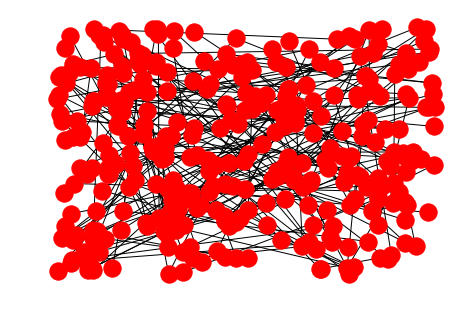

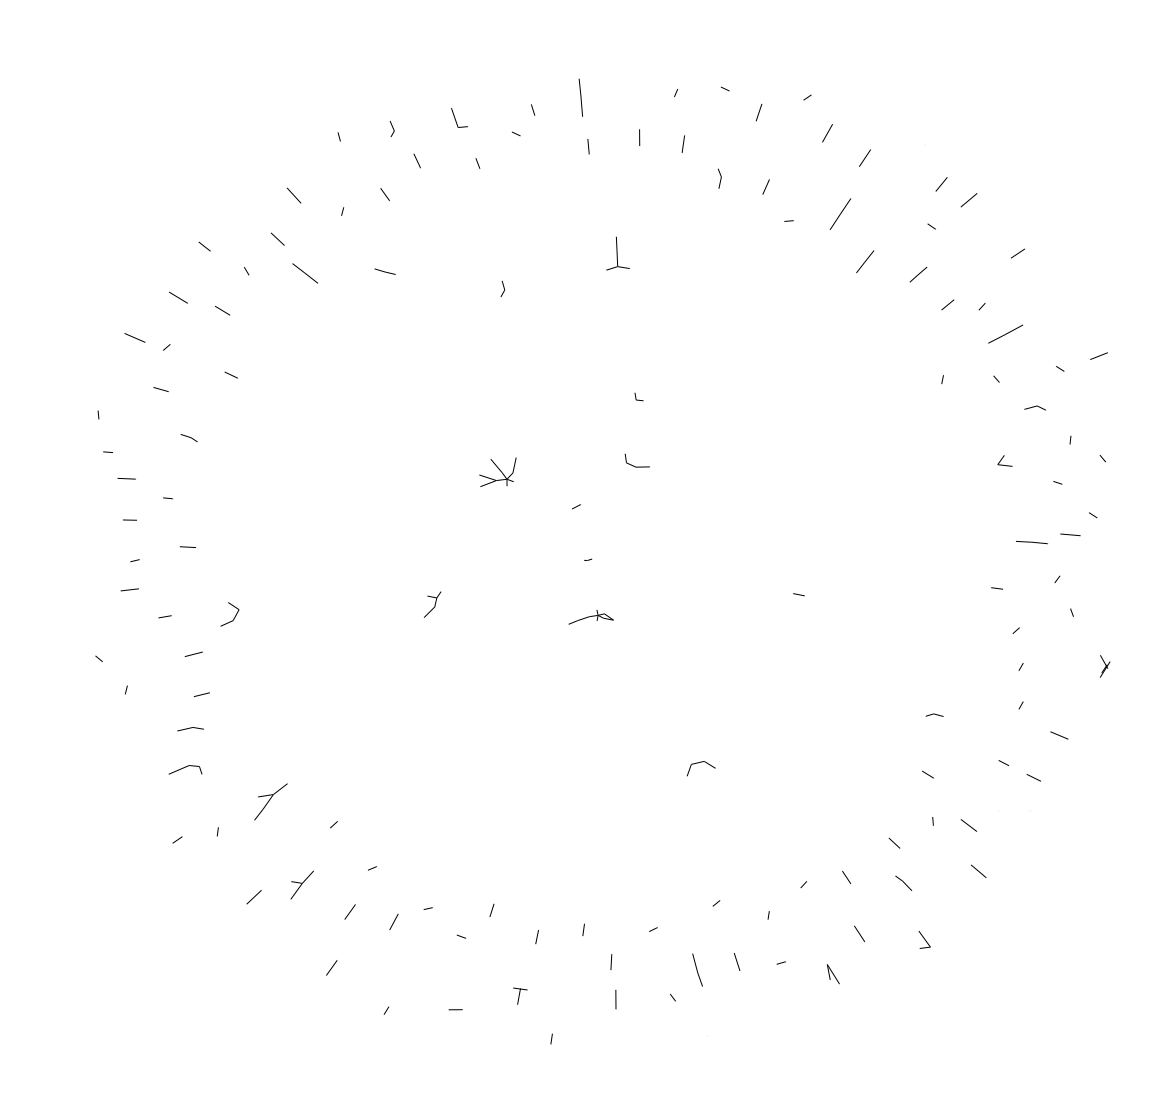

In [49]:
#In order to visualize your network (and charts) in the same notebook [No new window is opened], use:

%matplotlib inline



# Draw your network
nx.draw_random(G)
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [200.0 * G.degree(v) for v in G]
node_size =  [v * 100 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

#### Save the network

Save the resulting network in a 'gexf' file format. 
Save your metrics in a .csv file.

In [50]:
# Save network and metrics for later work
nx.write_gexf(G, "G1.gexf")




### 4. Community detection

In [21]:
# Import the chosen community detection library
# communty API : implements community detection 
import community

- determine the number of communities appropriate for the graph, and assigns each node a number, corresponding to the community it's a member of

In [22]:
communities = community.best_partition(G)
print(communities,10)

{'richard.shapiro': 0, 'blandford': 0, 'srosenberg': 0, 'steven.kean': 0, 'paul.hennemeyer': 0, 'paul.dawson': 0, 'peter.styles': 0, 'doug.wood': 0, 'orlando.gonzalez': 1, 'edgillespie': 0, 'john.sherriff': 2, 'lisa.yoho': 0, 'cbone': 0, 'ginger.dernehl': 0, 'harry.arora': 3, 'suresh.raghavan': 3, 'robert.saltiel': 3, 'saji.john': 3, 'jocelyn.gordon': 3, 'leonardo.pacheco': 0, 'carlos.alatorre': 4, 'jeff.bartlett': 3, 'dave.samuels': 5, 'yolanda.roberts': 3, 'mike.carson': 1, 'kenrcars': 1, 'heather.hill': 1, 'susan': 1, 'carson': 1, 'trpape': 1, 'tpape': 1, 'elizabethrhood': 1, 'mcarson': 1, 'cjackson': 1, 'rgibbs': 6, 'meridetk': 1, 'macharta': 1, 'wentapb': 1, 'jeff.king': 1, 'dttowns': 1, 'james.mairet': 1, 'discostars222': 1, 'john.zufferli': 1, 'matt.lorenz': 5, 'john.berger': 1, 'paul.broderick': 1, 'mark.davis': 1, 'kevin.presto': 1, 'john.suarez': 1, 'chad.starnes': 7, 'clint.dean': 1, 'kyle.schultz': 1, 'rogers.herndon': 1, 'robert.benson': 8, 'doug.gilbert-smith': 1, 'rlmich

- add the partition number to the network

In [23]:
nx.set_node_attributes(G, communities, 'modularity')

/home/aelma/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


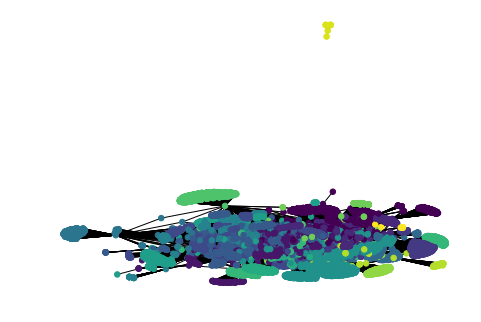

In [24]:
# Visualize your network with nodes colored according to their communities. Use cmap and node_color attributes 
com_value = [communities.get(node) for node in G.nodes()]
nx.draw_spring(G, cmp = ply.get_cmap('jet'), node_color = com_value, node_size = 30, with_labels = False)
ply.savefig('./net_comm.png')

<img src="./net_comm.png">

In [ ]:
# Calculate the performance measure of the chosen partioning method
mod = community.modularity(communities,G)
print("modularity :", mod)

### 5. Core-Periphery

The purpose of this section is to analyze the structure of your network, identify if it has a Core-Periphery structure and if so, inventory all nodes in the core.

Note: Remember that there are many types of Core-periphery structures. Also, a network may have more than one core.

In [ ]:
# Run algorithms and visualizations to identify Core-periphery structure (if existing)

import cpalgorithm as cpa # cpalgorithm contains several 
#algorithms to find core-peripheriy structure

lc = cpa.LapCore() # LapCore algo
lc.detect(G)# detect core-prephirey structure in net